In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime
from dateutil.relativedelta import relativedelta
from scipy.special import expit
from scipy.optimize import fmin, minimize
import glob as glob
import matplotlib
matplotlib.style.use('ggplot')

/Users/JohnnyV/anaconda2/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


In [2]:
def split_data(data):
    train_mask = (data.index < "2011")
    train = data[train_mask].cases
    test_mask = (data.index > "2010")
    test = data[test_mask].cases
    return train, test

In [3]:
provinces_df = pd.read_csv("all-dengues.csv")
provinces_df.index = pd.DatetimeIndex(provinces_df.date)
provinces_df = provinces_df.drop(['date','date.1'],axis=1)

cr_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangRai'].resample('W').size()
cr_dengues_df = pd.DataFrame(cr_dengues,columns=['cases'])
cr_train_test = split_data(cr_dengues_df)
cr_dengues_train, cr_dengues_test = cr_train_test[0], cr_train_test[1]

cm_dengues = provinces_df[provinces_df['จังหวัด'] == 'ChiangMai'].resample('W').size()
cm_dengues_df = pd.DataFrame(cm_dengues,columns=['cases'])
cm_train_test = split_data(cm_dengues_df)
cm_dengues_train, cm_dengues_test = cm_train_test[0], cm_train_test[1]

all_dengues = provinces_df.resample('W').size()
all_dengues_df = pd.DataFrame(all_dengues,columns=['cases'])
all_train_test = split_data(all_dengues_df)
all_dengues_train, all_dengues_test = all_train_test[0], all_train_test[1]

In [4]:
def make_line(start_week,real,predictions,title,x_axis,y_axis,
              real_legend='Real',predict_legend='Prediction'):
    plt.figure(figsize=(12,6))
    plt.plot([i for i in range(len(real))],np.array(real),'-r',label=real_legend)
    plt.plot([i for i in range(start_week,len(real)+1)],predictions,'-k',label=predict_legend,alpha=0.4)
    plt.axvline(start_week)
    plt.text((start_week*2)+10,300,'Prediction Start',horizontalalignment='center',verticalalignment='center')
    plt.xlabel(x_axis)
    plt.ylabel(y_axis)
    plt.legend()
    plt.title(title)

$$\sigma\,(w_{i}\cdot x_{i}) = \sum_{i=0}^{n} w_{i} x_{i}$$

$$Seasonal\,Part_{0} =\,\sin(\dfrac{\pi}{52}\,(x_{\,week\,to\,predict} - c)) + k$$

$$cases = (\sigma(w\cdot x) \,\times Seasonal\,Part) +\, k$$

## predict n weeks ahead by using the new set of betas
 
0-25: 29, 1-26: 30, 2-27: 31, 3-28:32, 4-29:33, 5-30:34

if the length of data is N, length of prediction would be N - (lag + week ahead)

ex. test case has length of 20, week ahead is 2, and lag is 4, the length of prediction would be 14

$$g(\bar{x}) = \bar{x}_{n+4}$$

$$x_{n+4} = g(x_{n},\,x_{n-1},\,x_{n-2},\,x_{n-3},\,....\,x_{n-LAG})$$

In [107]:
def guess(w,x_week,y_case):
    
    def sigma(w,y_case):
        pad_y = np.concatenate(([1],np.array(y_case)))
        all_cases = np.dot(w[:-3],pad_y)
        return all_cases

    def season_cos_sq(w,x_week):
        pi = np.math.pi
        coeff = pi/52.
        inside = (coeff*x_week) - (coeff*w[-2])
        cosine_sq = np.math.cos(inside)**2
        score = cosine_sq + w[-3]
        return score    
    
    return (sigma(w,y_case) * season_cos_sq(w,x_week)) + w[-1]

def get_alphas(LAG,train,constant,n_week_ahead):
    n_week = n_week_ahead - 1
    W_CASE = LAG + 1
    W_POP = 1
    W_SEASON = 2
    BETAS_SET = W_POP + W_CASE + W_SEASON # addition of ALL_WS betas

    # use poison instead of least square
    def cost(w):
        ret = 0
        for week_no in range(len(train)-(LAG+n_week)): # 4 weeks ahead of current week. LAG+(week ahead - 1)
            week_nth = week_no+LAG+n_week # future week starting 0th week. (week ahead - 1)
            print 'week_no', week_no
            print "week_nth", week_nth # 29
            print 'in train',train[week_no:week_no+LAG][0],train[week_no:week_no+LAG][-1] # train[0:29][-1] == train[28]
            real_case = train[week_nth] # 4 weeks ahead of current week. LAG+(week ahead - 1)
            print 'real',train[week_nth] # train[29]
            predicted_case = guess(w,week_nth,train[week_no:week_no+LAG]) #guess(26ws,week 29th,train[:26])
            print 'pred',predicted_case
            sigma_sq = real_case + 1 # assume poisson and avoid division by zero
            ret += ((real_case - predicted_case)**2)/float(sigma_sq)
#         print ret
        return ret

    seasonality_starters = [0.75,20] # [amplitude,constant,period,phase]
    arr = np.array([0.]*W_CASE) #  betas
#     arr = np.array(pd.read_csv('starter_ws.csv')['starter_ws'][:-1])
    arr = np.append(arr,seasonality_starters) # 29 betas
    arr = np.append(arr,constant) # 30 betas
    w = minimize(cost,arr)
    return w


In [109]:
# print cm_dengues_train[0:26][-1]
# print cm_dengues_train[25]
# print cm_dengues_train[:34]
print cm_dengues_train[:30]
print cm_dengues_train[29]

date
2003-01-05      1
2003-01-12      2
2003-01-19      5
2003-01-26      0
2003-02-02      2
2003-02-09      2
2003-02-16      1
2003-02-23      4
2003-03-02      3
2003-03-09      3
2003-03-16      2
2003-03-23      3
2003-03-30      3
2003-04-06      2
2003-04-13      3
2003-04-20      6
2003-04-27     10
2003-05-04     10
2003-05-11     18
2003-05-18     31
2003-05-25     25
2003-06-01     49
2003-06-08     76
2003-06-15     91
2003-06-22    101
2003-06-29    100
2003-07-06     97
2003-07-13     89
2003-07-20     95
2003-07-27    124
Freq: W-SUN, Name: cases, dtype: int64
124


In [108]:
get_alphas(26,cm_dengues_train,-9.26e-01,4)

week_no 0
week_nth 29
in train 1 100
real 124
pred -0.926
week_no 1
week_nth 30
in train 2 97
real 104
pred -0.926
week_no 2
week_nth 31
in train 5 89
real 103
pred -0.926
week_no 3
week_nth 32
in train 0 95
real 82
pred -0.926
week_no 4
week_nth 33
in train 2 124
real 74
pred -0.926
week_no 5
week_nth 34
in train 2 104
real 39
pred -0.926
week_no 6
week_nth 35
in train 1 103
real 51
pred -0.926
week_no 7
week_nth 36
in train 4 82
real 54
pred -0.926
week_no 8
week_nth 37
in train 3 74
real 45
pred -0.926
week_no 9
week_nth 38
in train 3 39
real 24
pred -0.926
week_no 10
week_nth 39
in train 2 51
real 27
pred -0.926
week_no 11
week_nth 40
in train 3 54
real 29
pred -0.926
week_no 12
week_nth 41
in train 3 45
real 27
pred -0.926
week_no 13
week_nth 42
in train 2 24
real 24
pred -0.926
week_no 14
week_nth 43
in train 3 27
real 28
pred -0.926
week_no 15
week_nth 44
in train 6 29
real 20
pred -0.926
week_no 16
week_nth 45
in train 10 27
real 8
pred -0.926
week_no 17
week_nth 46
in train 10

KeyboardInterrupt: 

In [94]:
cm_26_4weeks = get_alphas(26,cm_dengues_train,-9.26e-01,4) # 4 weeks ahead

In [84]:
cm_26_12weeks = get_alphas(26,cm_dengues_train,-9.26e-01,12)


In [30]:
cm_26.x

array([  3.09777961e+00,  -1.02208128e-02,  -1.31192513e-02,
        -5.97403596e-03,   7.91525469e-02,  -7.76587886e-02,
        -1.40507313e-02,  -7.24369918e-05,  -7.39008321e-02,
         6.94758682e-02,   1.57308925e-02,   3.43871064e-02,
        -8.53202360e-02,   5.87135091e-02,   1.25874902e-01,
        -6.12266218e-02,   1.86050868e-01,  -8.25779645e-02,
        -9.40390513e-02,   4.74162130e-02,  -1.24832780e-01,
         2.98427510e-02,  -1.11764464e-01,  -1.35281785e-01,
         4.00621954e-02,   1.73027937e-01,   1.02598129e+00,
         2.67254269e-01,   2.33300722e+01,  -1.20647233e+00])

In [120]:
cm_dengues_test[-30:]

date
2016-06-12     56
2016-06-19     52
2016-06-26     80
2016-07-03    126
2016-07-10    158
2016-07-17    159
2016-07-24    315
2016-07-31    380
2016-08-07    395
2016-08-14    420
2016-08-21    380
2016-08-28    317
2016-09-04    311
2016-09-11    249
2016-09-18    184
2016-09-25    153
2016-10-02    121
2016-10-09    106
2016-10-16     63
2016-10-23     28
2016-10-30     61
2016-11-06     78
2016-11-13     51
2016-11-20     51
2016-11-27     28
2016-12-04     29
2016-12-11     30
2016-12-18     14
2016-12-25     10
2017-01-01      4
Freq: W-SUN, Name: cases, dtype: int64

In [123]:
NWEEKS = 26
prediction_4week = []
# 2007 onward
train = cm_dengues_train
test = cm_dengues_test
train_test = cm_dengues_test[-30:] #cm_dengues_df.cases
# print train_test
for i in range(len(train_test)-(NWEEKS-1)):
    nth_week = i+NWEEKS+3
    print nth_week
    print train_test[i:i+NWEEKS][0],train_test[i:i+NWEEKS][-1]
    res = 0
    res = guess(cm_26_4weeks.x,nth_week,train_test[i:i+NWEEKS])
    prediction_4week.append(res)
    
prediction_4week
    
test_none = np.array(train_test)
test_none = np.append(test_none,[None]*0)
# make_line(26,test_none,prediction_4week,'Dengue Prediction: 4 week ahead',"","")
# plt.axvspan(0, len(train), color='blue', alpha=0.1)
# plt.text((len(train)/2)-25,900,'Train Period',size=16)
# plt.axvline(len(train)+1,linewidth=0.5, color='green')
# plt.text(len(train)+100,900,'Test Period',size=16)
# plt.axvspan(len(train)+1, len(train_test), color='green', alpha=0.1)
# # plt.axvline(416)
# # plt.axvline(420)

30
56 30


ValueError: shapes (27,) and (28,) not aligned: 27 (dim 0) != 28 (dim 0)

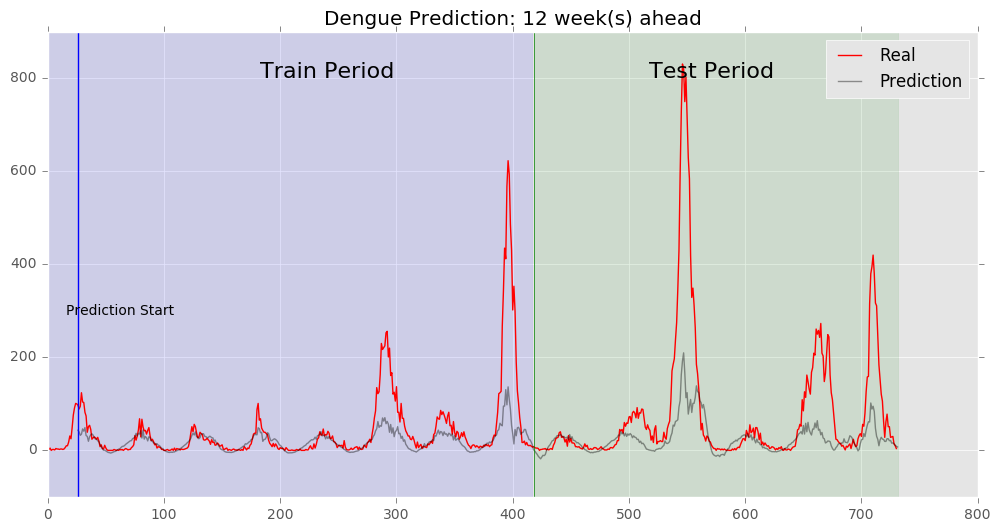

In [96]:
NWEEKS = 26
prediction_12week = []
# 2007 onward
train = cm_dengues_train
test = cm_dengues_test
train_test = cm_dengues_df.cases #cm_dengues_df.cases
# print train_test
for i in range(len(train_test)-(NWEEKS-1)):
    nth_week = i+NWEEKS+3
#     print week_to_predict+3
#     print train_test[i:i+NWEEKS][0],train_test[i:i+NWEEKS][-1]
    res = 0
    res = guess(cm_26_12weeks.x,nth_week,train_test[i:i+NWEEKS])
    prediction_12week.append(res)
    
# prediction_12week
    
test_none = np.array(train_test)
test_none = np.append(test_none,[None]*0)
make_line(26,test_none,prediction_12week,'Dengue Prediction: 12 week(s) ahead',"","")
plt.axvspan(0, len(train), color='blue', alpha=0.1)
plt.text((len(train)/2)-25,800,'Train Period',size=16)
plt.axvline(len(train)+1,linewidth=0.5, color='green')
plt.text(len(train)+100,800,'Test Period',size=16)
plt.axvspan(len(train)+1, len(train_test), color='green', alpha=0.1)

In [140]:
temp_cases = [i+1 for i in range(20)]
# n_week_ahead = 4
lag = 7
ct = 0
for week_no in range(len(temp_cases)-(lag-1)):
    print 'week_no',week_no+lag+3
    print temp_cases[week_no:week_no+lag]
    ct+=1
#     print 'real',temp_cases[week_no+lag+3]
ct

week_no 10
[1, 2, 3, 4, 5, 6, 7]
week_no 11
[2, 3, 4, 5, 6, 7, 8]
week_no 12
[3, 4, 5, 6, 7, 8, 9]
week_no 13
[4, 5, 6, 7, 8, 9, 10]
week_no 14
[5, 6, 7, 8, 9, 10, 11]
week_no 15
[6, 7, 8, 9, 10, 11, 12]
week_no 16
[7, 8, 9, 10, 11, 12, 13]
week_no 17
[8, 9, 10, 11, 12, 13, 14]
week_no 18
[9, 10, 11, 12, 13, 14, 15]
week_no 19
[10, 11, 12, 13, 14, 15, 16]
week_no 20
[11, 12, 13, 14, 15, 16, 17]
week_no 21
[12, 13, 14, 15, 16, 17, 18]
week_no 22
[13, 14, 15, 16, 17, 18, 19]
week_no 23
[14, 15, 16, 17, 18, 19, 20]


14